In [16]:

import bempp.api 
bempp.api

import numpy as np
from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator

bempp.api.enable_console_logging()

k0 = 1
mu0 = 1
refractivei = [1.5, 1.2]
mui = [1., 1.]

M = 2
segments = [[10], [10]]
swapped_normals = [[10], []]

precision = 10
h = 2 * np.pi/(precision*k0)

grid = bempp.api.shapes.sphere(h=h)


bempp:HOST:INFO: Created grid with id 3c96f65d-c1b4-455a-93c7-dc22975ddf34. Elements: 112. Edges: 168. Vertices: 58


In [17]:
k_list = [k0] 
mu_list = [mu0]
for index in range(M-1):
  k_list.append(refractivei[index] * k0)
  mu_list.append(mui[index])

print(k_list, 'k_list')
    
dA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
rA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
tA = [bempp.api.function_space(grid, "SNC", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

[1, 1.5] k_list


In [18]:
multitrace_ops = []
# > Assemble all diagonal operators
for index in range(M):
  k = k_list[index]
  mu = mu_list[index]
  efie = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k)
  mfie = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k)
  multitrace_ops.append(bempp.api.GeneralizedBlockedOperator([[mfie, mu/k * efie],[- k/mu * efie, mfie]]))

# Define the final operator

block_system = [M * [None] for _ in range(M)]

for i in range(M):
  for j in range(M):
    if i == j:
      block_system[i][j] = 2 * multitrace_ops[i]
    else:
      all = segments[i] + segments[j]
      non_disjoint = np.unique(all).shape[0] != len(all)
      
      if non_disjoint:
        ident = identity(dA[j], rA[i], tA[i])
        op = BlockedOperator(2, 2)
        #op[0, 0] = -ident
        op[0, 0] = ident
        op[1, 1] = ident
        op.weak_form()
        #op[1, 1] = ident
        block_system[i][j] = op
      else:
        op = BlockedOperator(2, 2)
        zero = ZeroBoundaryOperator(dA[j], rA[i], tA[i])
        op[0, 0] = zero
        op[1, 1] = zero
        block_system[i][j] = op

block_system = GeneralizedBlockedOperator(block_system)


In [19]:

def incident_field_z(x):
    return np.array([0. * x[0], 0. * x[0], np.exp(1j * k0 * x[0])])


@bempp.api.complex_callable
def dirichlet_trace_z(x, n, domain_index, result):
    incident_field_z = np.array([0. * x[0], 0. * x[0], np.exp(1j * k0 * x[0])])
    result[:] = np.cross(incident_field_z, n)


@bempp.api.complex_callable
def neumann_trace_z(x, n, domain_index, result):
    curl_z = np.array([x[0] * 0. ,-1j * k0 * np.exp(1j * k0 * x[0]), x[0] * 0.])
#     with objmode():
    result[:] = (1/(1j * k0)) * np.cross(curl_z, n)

rhs = [ -2 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=dirichlet_trace_z),
        -2 * k0 / mu0 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=neumann_trace_z)]
for i in range(1, M):
    zero_func = [bempp.api.GridFunction.from_zeros(dA[i]),bempp.api.GridFunction.from_zeros(dA[i])]
    rhs = rhs + zero_func



In [20]:
block_system_wf = block_system.weak_form()


In [21]:
print('weak_form')
block_system_wf = block_system.weak_form()
print('matrix')
A = bempp.api.as_matrix(block_system_wf)
print(A.shape, 'Ashape')
print('direct solver')
b = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(rhs, block_system.dual_to_range_spaces)
x = np.linalg.solve(A, b)
sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(x.ravel(), block_system.domain_spaces)


weak_form
matrix
(672, 672) Ashape
direct solver


We compute the Far-Field pattern:
    

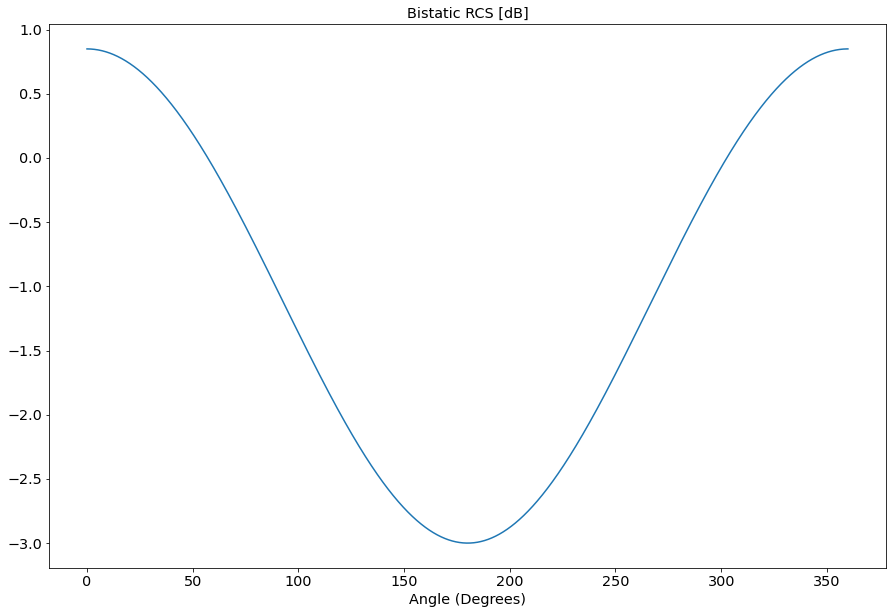

In [22]:
number_of_angles = 3601
angles = np.pi * np.linspace(0, 2, number_of_angles)
unit_points = np.array([np.cos(angles), np.sin(angles), np.zeros(number_of_angles)])


electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[1].space, unit_points, k0)
magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[0].space, unit_points, k0)    

far_field = - electric_far * sol[1] * mu0 / k0 - magnetic_far * sol[0]

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10) # Increase the figure size in the notebook
params = {'legend.fontsize': 'x-large', 'axes.labelsize': 'x-large', 'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs)

plt.title("Bistatic RCS [dB]")
_ = plt.xlabel('Angle (Degrees)')

In [23]:
x

array([-6.06460575e-01+3.25686560e-01j,  5.13167199e-01-1.21940547e-01j,
        6.18432980e-02+8.52847394e-02j,  3.42665830e-01-3.63078121e-01j,
       -3.38920809e-01+4.32484372e-01j, -8.56779994e-02+6.15718000e-02j,
        5.54595048e-02-1.27749527e-03j,  3.70777257e-01-3.63765131e-01j,
        5.28387327e-03+1.16334127e-02j,  7.18952580e-01+8.58649585e-02j,
       -4.33993470e-01+4.30331010e-01j, -9.64418009e-03-1.08930650e-02j,
        5.38624606e-01+7.30417073e-02j, -3.55600482e-01+1.79731591e-01j,
       -4.59443932e-01+2.52239007e-01j, -4.97479776e-02+1.72097432e-01j,
       -4.12966079e-01+5.59469665e-01j, -9.21114058e-02+1.55233568e-01j,
        1.96178556e-01-1.51899184e-01j, -1.67352787e-01+2.04266683e-01j,
        1.84530063e-01+2.74591145e-02j, -3.57987413e-01+6.07150888e-01j,
        2.80420312e-01-4.70851351e-01j, -6.25268653e-03+3.19964600e-03j,
        2.34073631e-01-1.46428217e-01j, -1.76648440e-03-1.09765870e-01j,
       -2.63492525e-01+1.83806605e-01j, -3.24584080